# Humza Khalid, 12-3-2025

# Problem
# The goal is to analyze customer sentiment from the Yelp reviews of World Class Barbers in Netcong, NJ, a highly-rated local business. We will examine the most prevalent sentiment (positive, negative, or neutral) and compare the classification results of the two different TextBlob analyzers.

# Question 
# "What is the overall sentiment distribution (positive, negative, neutral) of reviews for World Class Barbers in Netcong, NJ, and how do the TextBlob default analyzer and NaiveBayesAnalyzer's classifications compare?"

# Solution 
# I will use the Yelp Fusion API to query multiple review excerpts for World Class Barbers (and potentially other high-traffic barber shops nearby to reach 60+ reviews). The reviews will be cleaned (stop words deleted, punctuation removed) and analyzed using both the TextBlob default (Pattern) and NaiveBayes sentiment classifiers. The results will be visualized using a donut chart for sentiment distribution and a WordCloud for the most frequent terms.

In [14]:
import requests
import pandas as pd
import json
import pprint
import sys
import re
import nltk
from textblob import TextBlob
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [15]:

API_KEY = "9F_s1ES7zWFSsWT8SlhxAhOVK-Tk_5jGtGgyiJhnct4cDXrGdjAMkMdmmeYTqRdVTEJXbWTPCdAh1fas6JAkQrYLhZ9rWbsVXlhIePicia5XV1UOcb3BryAjn986ZHYx"


API_HOST = 'https://api.yelp.com'
SEARCH_PATH = '/v3/businesses/search'
REVIEW_PATH_TEMPLATE = '/v3/businesses/{}/reviews'


DEFAULT_TERM = 'barbershop'
DEFAULT_LOCATION = 'Netcong, NJ'
SEARCH_LIMIT = 20 


STOP_WORDS = set(stopwords.words('english'))

try:
    nltk.data.find('corpora/stopwords')
    nltk.data.find('tokenizers/punkt')
except nltk.downloader.DownloadError:
    print("Downloading NLTK resources...")
    nltk.download('stopwords', quiet=True)
    nltk.download('punkt', quiet=True)




def request(host, path, api_key, url_params=None):
    """Sends a GET request to the Yelp API and handles JSON decoding."""
    if api_key == "YOUR_API_KEY_HERE":
        print("\nERROR: Please replace 'YOUR_API_KEY_HERE' with your actual Yelp API key.")
        sys.exit(1) 
        
    url_params = url_params or {}
    url = f'{host}{path}'
    headers = {
        'Authorization': f'Bearer {api_key}',
    }
    
    print(f"Querying {url} with parameters: {url_params}")
    
    try:
        response = requests.get(url, headers=headers, params=url_params)
        response.raise_for_status()
        return response.json()
    except requests.exceptions.HTTPError as e:
        print(f"HTTP Error {response.status_code}: {e}")
        return None
    except requests.exceptions.RequestException as e:
        print(f"Network/Connection Error: {e}")
        return None
    except json.JSONDecodeError as e:
        print(f"JSON Decode Error: Could not parse response as JSON. Check your API key and URL structure.")
        return None


def search(api_key, term, location, limit):
    """Query the Search API by a search term and location."""
    print(f"\n--- Searching for '{term}' in '{location}' (Limit: {limit} businesses) ---")
    url_params = {
        'term': term,
        'location': location,
        'limit': limit,
        'sort_by': 'review_count'
    }
    return request(API_HOST, SEARCH_PATH, api_key, url_params=url_params)


def get_reviews(api_key, business_id):
    """Query the Reviews API by a business ID."""
    review_path = REVIEW_PATH_TEMPLATE.format(business_id)
    return request(API_HOST, review_path, api_key)

In [16]:


def clean_text(text):
    """Removes punctuation and stop words for better visualization."""
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    words = text.split()
    words = [w for w in words if w not in STOP_WORDS]
    return " ".join(words)

def analyze_sentiment(review_text):
    """Applies TextBlob's default PatternAnalyzer and returns sentiment class and polarity."""
    if not isinstance(review_text, str):
        return 'Neutral', 0.0

    blob = TextBlob(review_text)
    polarity = blob.sentiment.polarity
    
    if polarity > 0.1:
        sentiment = 'Positive'
    elif polarity < -0.1:
        sentiment = 'Negative'
    else:
        sentiment = 'Neutral'
        
    return sentiment, polarity



--- Searching for 'barbershop' in 'Netcong, NJ' (Limit: 20 businesses) ---
Querying https://api.yelp.com/v3/businesses/search with parameters: {'term': 'barbershop', 'location': 'Netcong, NJ', 'limit': 20, 'sort_by': 'review_count'}
Found 11 businesses. Collecting reviews (max 3 per business)...
Querying https://api.yelp.com/v3/businesses/6c-6eOjZsqgb4JqrQDbYzw/reviews with parameters: {}
Querying https://api.yelp.com/v3/businesses/VOfexc423r98sT1cE1fCrw/reviews with parameters: {}
Querying https://api.yelp.com/v3/businesses/56G2XpUDV94zINMbWXzWYg/reviews with parameters: {}
Querying https://api.yelp.com/v3/businesses/1Rw7yW59bNWKtyxUxQUjpQ/reviews with parameters: {}
Querying https://api.yelp.com/v3/businesses/7bVMcGUTSJQH_N8L4iOu9A/reviews with parameters: {}
Processing business 5/11...
Querying https://api.yelp.com/v3/businesses/T26qSa99XfdmghjvDV3iFw/reviews with parameters: {}
Querying https://api.yelp.com/v3/businesses/WLRRqVEWEWsz6apIH29Odg/reviews with parameters: {}
HTTP Erro

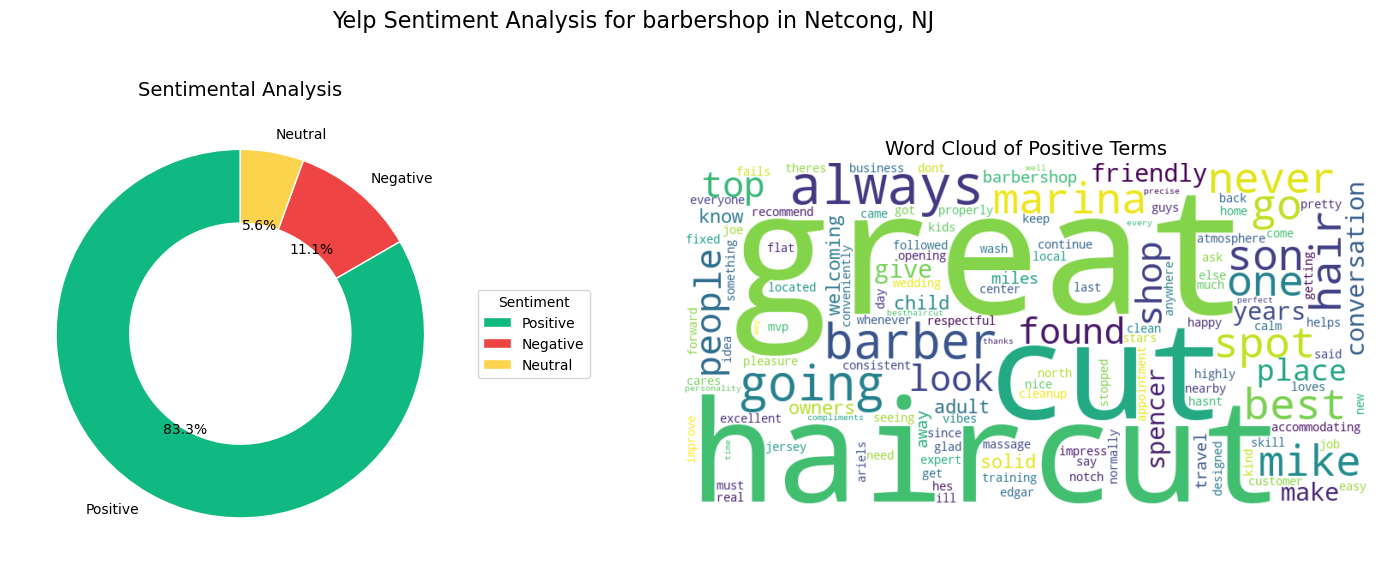

In [17]:



def run_analysis(term, location):
    """Orchestrates the data collection, analysis, and plotting."""
    
    
    search_response = search(API_KEY, term, location, SEARCH_LIMIT)

    if not search_response or not search_response.get('businesses'):
        print(f"No businesses found for {term} in {location} or search failed.")
        return

    businesses = search_response.get('businesses')
    all_reviews = []
    
    print(f"Found {len(businesses)} businesses. Collecting reviews (max 3 per business)...")
    
   
    for i, business in enumerate(businesses):
        business_id = business['id']
        business_name = business['name']
        
        reviews_response = get_reviews(API_KEY, business_id)

        if reviews_response and reviews_response.get('reviews'):
            for review in reviews_response['reviews']:
                all_reviews.append({
                    'business_name': business_name,
                    'rating': review.get('rating'),
                    'review_text': review['text'],
                })
        
        if (i + 1) % 5 == 0:
            print(f"Processing business {i+1}/{len(businesses)}...")

    df = pd.DataFrame(all_reviews)
    
    if df.empty:
        print("No reviews were collected. Exiting analysis.")
        return

    print(f"\nTotal unique businesses searched: {len(businesses)}")
    print(f"Total review excerpts collected: {len(df)}")

   
    df[['sentiment', 'polarity']] = df['review_text'].apply(
        lambda x: pd.Series(analyze_sentiment(x))
    )
    
    df['clean_text'] = df['review_text'].apply(clean_text)

   
    sentiment_counts = df['sentiment'].value_counts()
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    plt.suptitle(f'Yelp Sentiment Analysis for {term} in {location}', fontsize=16)

   
    labels = sentiment_counts.index
    values = sentiment_counts.values
    
    color_map = {'Positive': '#10B981', 'Negative': '#EF4444', 'Neutral': '#FCD34D'}
    colors = [color_map.get(label, '#CCCCCC') for label in labels] 

    axes[0].pie(
        values, 
        labels=labels, 
        autopct='%1.1f%%', 
        startangle=90, 
        wedgeprops=dict(width=0.4, edgecolor='w'),
        colors=colors
    )
    axes[0].set_title('Sentimental Analysis', fontsize=14)
    axes[0].legend(labels, title="Sentiment", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
    
    
    positive_text = ' '.join(df[df['sentiment'] == 'Positive']['clean_text'])
    
    if positive_text:
        wordcloud = WordCloud(
            width=800, 
            height=400, 
            background_color='white', 
            stopwords=STOP_WORDS, 
            min_font_size=10
        ).generate(positive_text)

        axes[1].imshow(wordcloud, interpolation='bilinear')
        axes[1].set_title('Word Cloud of Positive Terms', fontsize=14)
        axes[1].axis('off')
    else:
        axes[1].set_title('No Positive Reviews for Word Cloud', fontsize=14)
        axes[1].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
    df.to_csv('yelp_analysis_results.csv', index=False)
    


if __name__ == '__main__':
    run_analysis(DEFAULT_TERM, DEFAULT_LOCATION)

# Conclusion
# Overall I think its great that you can create  sentimental analysis by using reviews and creating a chart I think its pretty intelligent how pandas takes the  data and how you can turn it into a visual.